Hak Artem, MP CS-2
Neural Networks, Lab 2

Домашнє завдання 2: Використання глибоких мереж

Для виконання цього завдання, використайте код з попередніх практичних і домашніх.

Виберіть прикладну задачу, яку хочете вирішити за допомогою нейронних мереж. Знайдіть для неї датасет, наприклад, з kaggle.com.
Визначте які популярні архітектури можуть підійти для виконання задачі. Скористайтеся офіційною документацією для більшої інформації: https://pytorch.org/vision/stable/models.html.
Визначте основні компоненти моделі: функція втрат, функція метрики, яку базову архітектуру моделі (яку передтреновану модель) будете використовувати.
Використайте код з попередніх практичних і домашніх робіт та модифікуйте його для роботи з вашим датасетом та передтренованою моделлю.
Проведіть експерименти з обраними архітектурами, порівняйте їх, зробіть і напишіть висновки.
Зробіть fine-tuning передтренованої моделі та/або tuning гіпер (мета) параметрів.


Рішення необхідно оформити як .ipynb або .py файл з описом ваших роздумів (1-2 речення з коментарем щодо вашого застосування тих чи інших підходів і структур нейронних мереж).
https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

-------------------------------------------------------------------------------------------------------------------------------

**Я вибрав датасет для класифікації гральних карт за фото**

https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import pandas as pd
import torchvision

from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torchvision.utils import make_grid

import random
from tqdm import tqdm
import numpy as np
import cv2
import time
import torch.optim as optim
import opendatasets as od
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [3]:
od.download(
    "https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification")

Skipping, found downloaded files in ".\cards-image-datasetclassification" (use force=True to force download)


In [4]:
train_dir = "./cards-image-datasetclassification/train/"
valid_dir = "./cards-image-datasetclassification/valid/"
test_dir = "./cards-image-datasetclassification/test/"

In [376]:
batch_size = 32
img_height = 80
img_width = 80

In [377]:
# Define transformations for your images
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),  # Resize images to a consistent size
    transforms.ToTensor(),        # Convert images to tensors
    # Add other transformations as needed (e.g., normalization)
])

In [210]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

In [211]:
validation_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

In [378]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(dataset=test_dataset, shuffle=False)

In [213]:
plt_size = 2
plt_images = 12

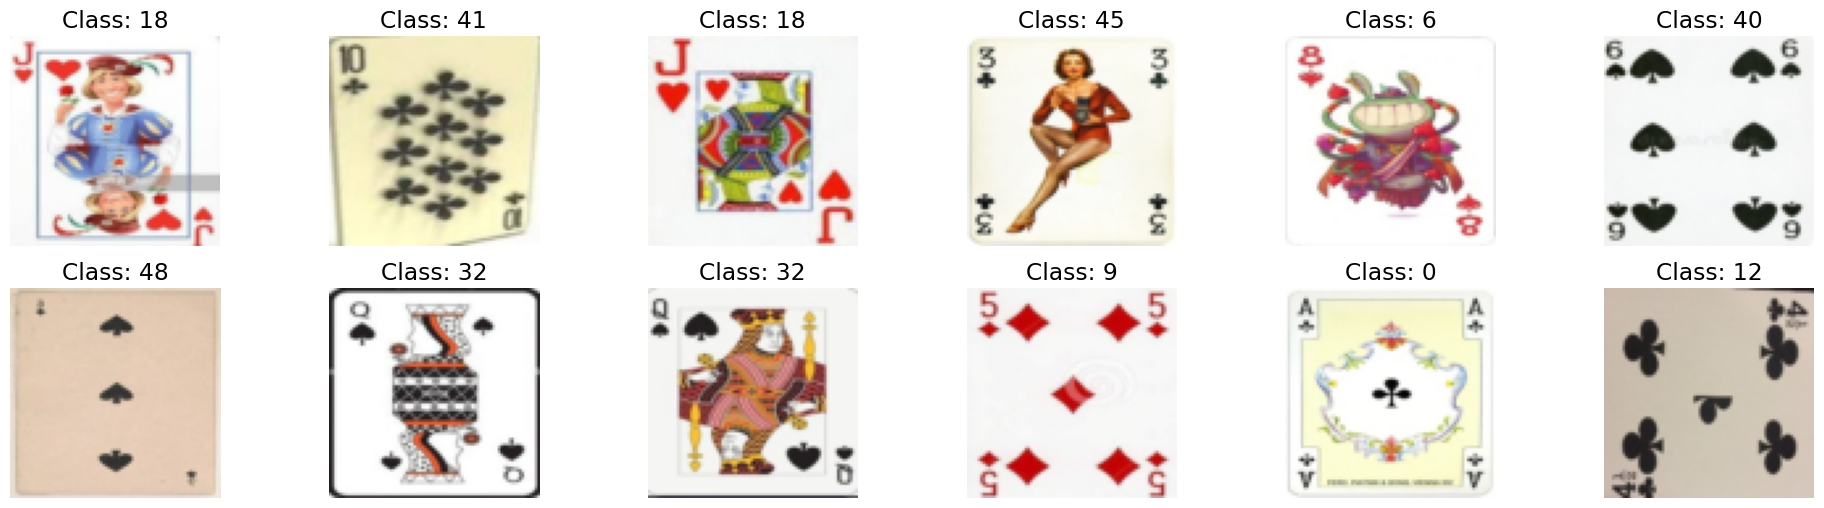

In [214]:
for (X_train, y_train) in train_loader:
    plt.figure(figsize=(plt_images * plt_size, 3 * plt_size))

    for i in range(plt_images):
        plt.subplot(2, plt_images // 2, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i].permute(1, 2, 0), cmap="gray")  # Reshape the tensor for display
        plt.title(f'Class: {y_train[i].item()}')

    break  # Display one batch
plt.show()

In [215]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

class_counts = defaultdict(int)  # Dictionary to store class counts

# Loop through the entire dataset to count class occurrences
for _, y_train in train_loader:
    for label in y_train.numpy():
        class_counts[label] += 1

# Convert dictionary to arrays for plotting
unique_classes, counts = zip(*class_counts.items())

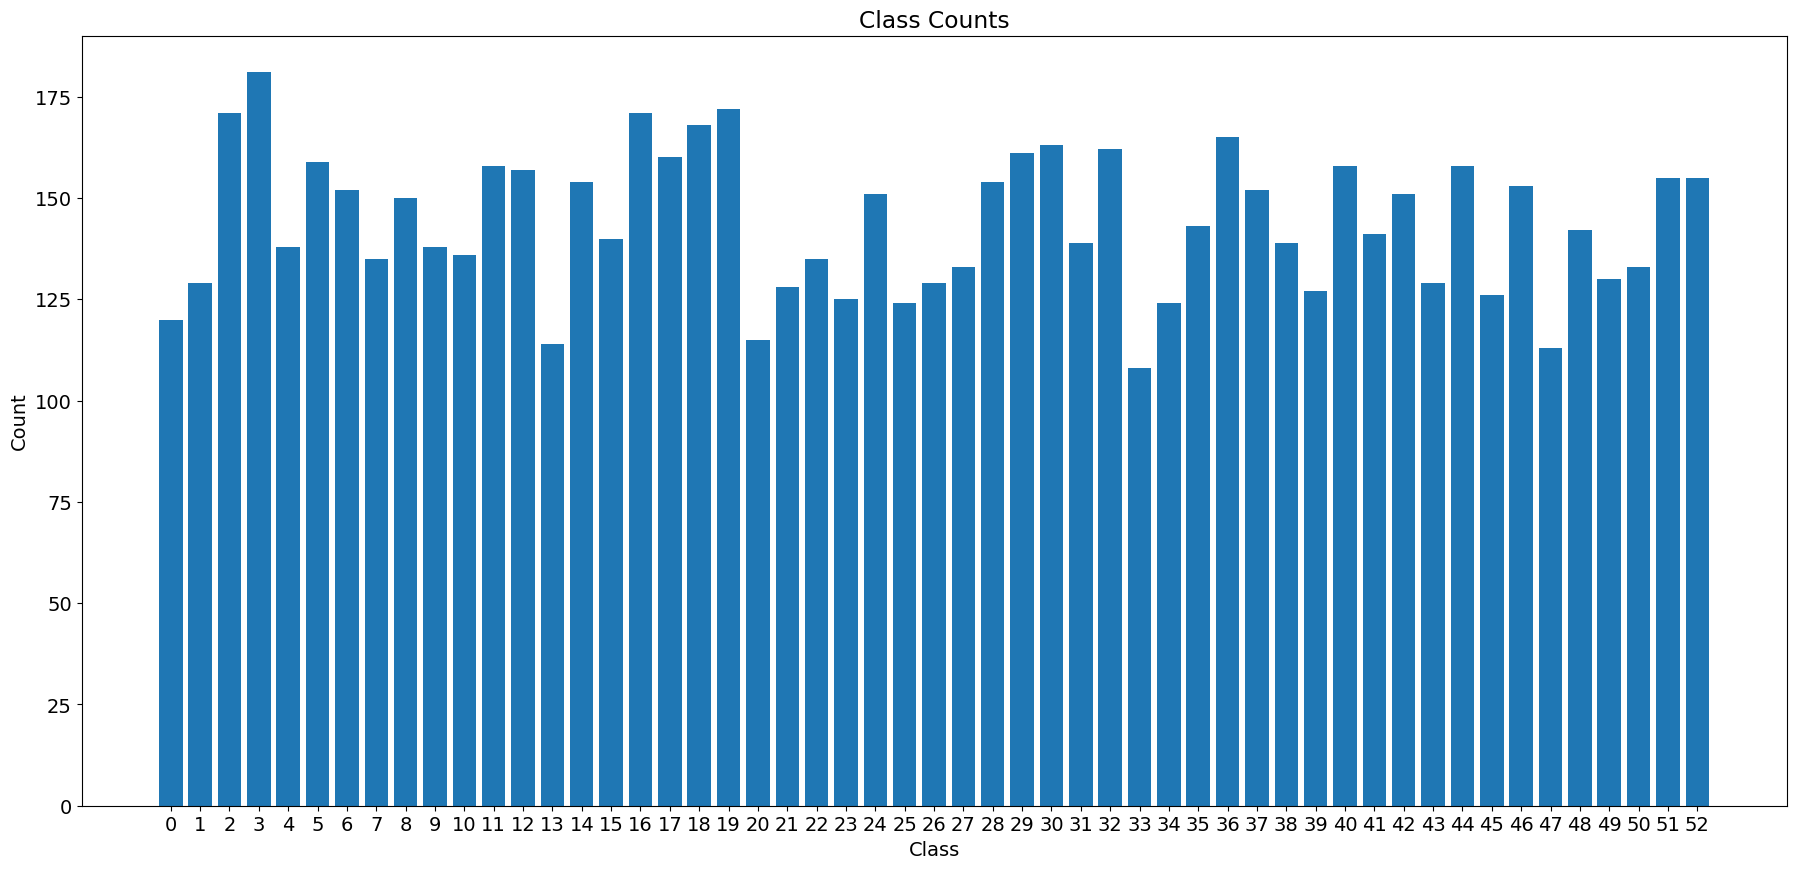

In [216]:
# Create a bar plot for class counts
plt.figure(figsize=(22, 10))
plt.bar(unique_classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Counts')
plt.xticks(np.arange(min(unique_classes), max(unique_classes) + 1, 1))
plt.show()

# Model 1: Basic model

In [168]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=img_height*img_width*3, num_classes=53, hidden_sizes=[8192, 2048, 512, 256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [169]:
model = BaseNetwork(act_fn=nn.ReLU()).to(device)

In [170]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [171]:
criterion = nn.CrossEntropyLoss()

In [172]:
model

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=19200, out_features=8192, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8192, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=53, bias=True)
  )
)

In [173]:
def train(model, epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [174]:
def validate(model, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [175]:
%%time
epochs = 25

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model, epoch)
    validate(model, lossv, accv)

Train Epoch: 1 [0/7624 (0%)]	Loss: 3.966094
Train Epoch: 1 [6400/7624 (84%)]	Loss: 3.966455

Validation set: Average loss: 3.9674, Accuracy: 5/265 (2%)

Train Epoch: 2 [0/7624 (0%)]	Loss: 3.979606
Train Epoch: 2 [6400/7624 (84%)]	Loss: 3.958509

Validation set: Average loss: 3.9570, Accuracy: 11/265 (4%)

Train Epoch: 3 [0/7624 (0%)]	Loss: 3.966908
Train Epoch: 3 [6400/7624 (84%)]	Loss: 3.925764

Validation set: Average loss: 3.9042, Accuracy: 11/265 (4%)

Train Epoch: 4 [0/7624 (0%)]	Loss: 3.875900
Train Epoch: 4 [6400/7624 (84%)]	Loss: 3.693332

Validation set: Average loss: 3.6362, Accuracy: 21/265 (8%)

Train Epoch: 5 [0/7624 (0%)]	Loss: 3.779953
Train Epoch: 5 [6400/7624 (84%)]	Loss: 3.583157

Validation set: Average loss: 3.7027, Accuracy: 12/265 (5%)

Train Epoch: 6 [0/7624 (0%)]	Loss: 3.926451
Train Epoch: 6 [6400/7624 (84%)]	Loss: 3.463831

Validation set: Average loss: 3.1913, Accuracy: 35/265 (13%)

Train Epoch: 7 [0/7624 (0%)]	Loss: 3.656288
Train Epoch: 7 [6400/7624 (84%)]

Text(0.5, 1.0, 'validation loss')

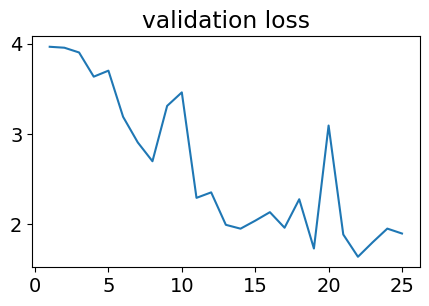

In [179]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

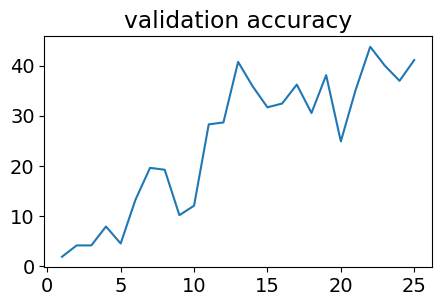

In [180]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [183]:
%%time
#more train
from_epochs = 26
to_epochs = 32
for epoch in range(from_epochs, to_epochs + 1):
    train(model, epoch)
    validate(model, lossv, accv)

Train Epoch: 26 [0/7624 (0%)]	Loss: 2.252222
Train Epoch: 26 [6400/7624 (84%)]	Loss: 2.214306

Validation set: Average loss: 1.9468, Accuracy: 103/265 (39%)

Train Epoch: 27 [0/7624 (0%)]	Loss: 2.483544
Train Epoch: 27 [6400/7624 (84%)]	Loss: 1.370115

Validation set: Average loss: 1.7558, Accuracy: 114/265 (43%)

Train Epoch: 28 [0/7624 (0%)]	Loss: 2.081817
Train Epoch: 28 [6400/7624 (84%)]	Loss: 1.892401

Validation set: Average loss: 1.8150, Accuracy: 118/265 (45%)

Train Epoch: 29 [0/7624 (0%)]	Loss: 1.806772
Train Epoch: 29 [6400/7624 (84%)]	Loss: 1.836516

Validation set: Average loss: 1.8469, Accuracy: 121/265 (46%)

Train Epoch: 30 [0/7624 (0%)]	Loss: 2.330791
Train Epoch: 30 [6400/7624 (84%)]	Loss: 1.288097

Validation set: Average loss: 2.1757, Accuracy: 95/265 (36%)

Train Epoch: 31 [0/7624 (0%)]	Loss: 1.929771
Train Epoch: 31 [6400/7624 (84%)]	Loss: 1.752905

Validation set: Average loss: 1.6613, Accuracy: 126/265 (48%)

Train Epoch: 32 [0/7624 (0%)]	Loss: 1.969564
Train Ep

Text(0.5, 1.0, 'validation loss')

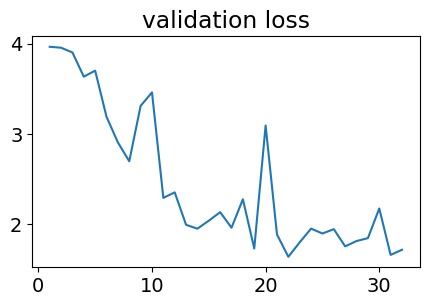

In [185]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,to_epochs+1), lossv)
plt.title('validation loss')

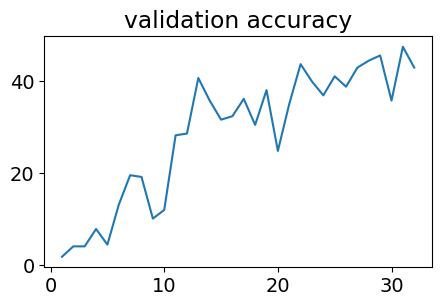

In [186]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,to_epochs+1), accv)
plt.title('validation accuracy');

In [248]:
def transform_image(img):
    ang_range = 25
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))

    return img

def get_random_image_of_given_label(images_set, labels_set, label):
    image_indexes = np.where(labels_set == label)
    rand_index = random.randint(0, np.bincount(labels_set)[label] - 1)
    return images_set[image_indexes][rand_index]

def equalize_samples_set(X_set, y_set, image_height, image_width, num_channels):
    # Convert y_set to integer type
    y_set = y_set.astype(np.int64)

    labels_count_arr = np.bincount(y_set)
    labels_bins = np.arange(len(labels_count_arr))

    for label in tqdm(labels_bins, position=0, leave=True):
        labels_no_to_add = int(np.mean(labels_count_arr)) * 2 - labels_count_arr[label]

        X_temp = []
        y_temp = []

        for num in range(labels_no_to_add):
            rand_image = get_random_image_of_given_label(X_set, y_set, label)
            transformed_image = transform_image(rand_image)
            X_temp.append(transformed_image)
            y_temp.append(label)

        X_temp = np.array(X_temp)  # Convert list to NumPy array
        X_temp = X_temp.reshape(-1, num_channels, image_height, image_width, )  # Reshape to match image dimensions

        X_set = np.append(X_set, X_temp, axis=0)
        y_set = np.append(y_set, np.array(y_temp), axis=0)

    return X_set, y_set


In [280]:
X_train_eq = []
y_train_eq = []

for batch in train_loader:
    data, target = batch  # Assuming each batch contains data and labels
    # Assuming data and target are tensors, convert them to numpy arrays if needed
    data_np = data.numpy()  # Convert data tensor to numpy array
    target_np = target.numpy()  # Convert target tensor to numpy array

    X_train_eq.append(data_np)
    y_train_eq.append(target_np)

# Convert lists to numpy arrays
X_train_eq = np.concatenate(X_train_eq, axis=0)
y_train_eq = np.concatenate(y_train_eq, axis=0)


In [281]:
X_train[0].shape

torch.Size([3, 80, 80])

In [ ]:
#n_train = len(X_train)
#X_train, y_train = equalize_samples_set(X_train, y_train)

# Usage example
n_train = len(X_train)
num_channels, image_height, image_width = X_train[0].shape
print(image_height)
print(image_width)
print(num_channels)
X_train, y_train = equalize_samples_set(X_train, y_train, image_height, image_width, num_channels)

In [252]:
len(X_train)

15158

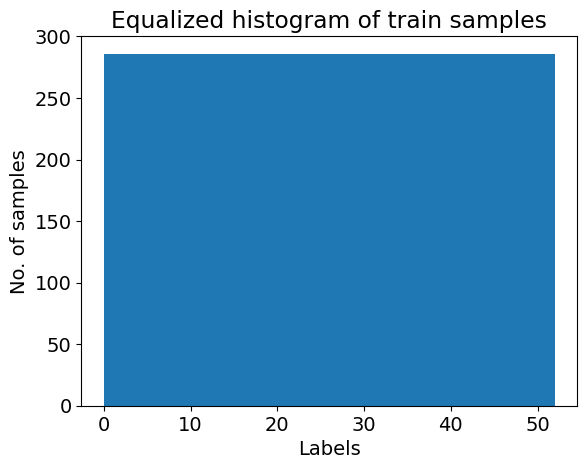

Train set increased from 7624 to 15158


In [256]:
n, bins, patches = plt.hist(y_train, len(set(y_train)))
plt.xlabel('Labels')
plt.ylabel('No. of samples')
plt.title('Equalized histogram of train samples')
plt.show()

print("Train set increased from {} to {}".format(n_train,X_train.shape[0]))

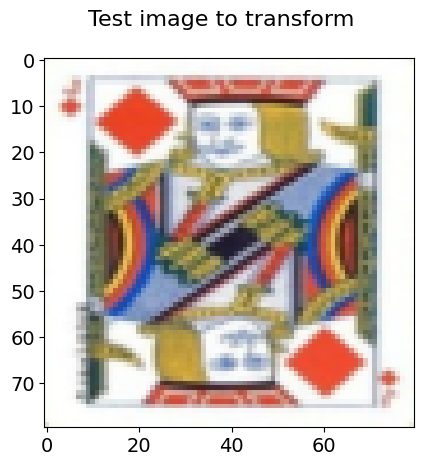

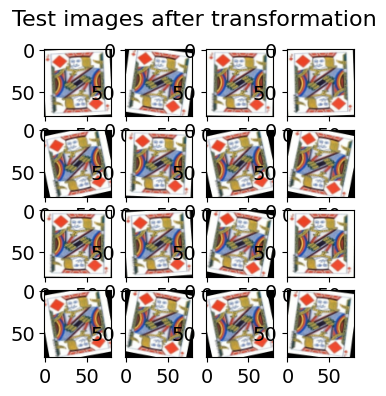

In [261]:
fig=plt.figure()
fig.suptitle('Test image to transform', fontsize=16)
plt.imshow(np.transpose(X_train[999], (1, 2, 0)))

grid_len = 4
fig=plt.figure(figsize=(grid_len,grid_len))
fig.suptitle('Test images after transformation', fontsize=16)

for i in range(1,grid_len*grid_len+1):
    image = transform_image(np.transpose(X_train[999], (1, 2, 0)))
    plt.subplot(grid_len,grid_len,i)
    plt.imshow(image)

Pre-trained models

In [306]:
import torch
import torchvision.models as models

# Load a pretrained model (e.g., ResNet50)
model = models.resnet50(pretrained=True)
# Replace the final fully connected layer for your specific number of classes
num_classes = 53  # For playing cards
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Data preprocessing and loading
# Define transforms (resizing, normalization, etc.)
transform = torchvision.transforms.Compose([
    # Add other transformations as needed
])



In [303]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [307]:
X_train_eq[0].shape

(3, 80, 80)

In [308]:
len(X_train_eq)

7624

In [299]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [309]:
custom_dataset = CustomDataset(X_train_eq, y_train_eq)

In [310]:
train_loader = DataLoader(dataset=custom_dataset, shuffle=True, batch_size=batch_size)

In [311]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [342]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def accuracy(y_pred, y_true):
    # Calculate accuracy
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    acc = correct / y_true.size(0)
    return acc

# Your training loop
def train(model, train_loader, criterion, optimizer, num_epochs, lossv, accv, train_loss, train_acc, patience=10):
    
    wait = 0
    valid_loss_min = np.Inf
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_accuracy += accuracy(outputs, labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = running_accuracy / len(train_loader)
        
        validate(model, lossv, accv)
        valid_loss = lossv[-1]
        # Save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
            torch.save(model.state_dict(), 'modelResNet.pt')
            valid_loss_min = valid_loss
            wait = 0
        # Early stopping
        else:
            wait += 1
            if wait >= patience:
                print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
        train_loss.append(epoch_loss)
        train_acc.append(epoch_accuracy)
        print(f"Train Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")




In [343]:
%%time
lossv, accv = [], []
train_loss, train_acc = [], []
# Usage example
num_epochs = 30
train(model, train_loader, criterion, optimizer, num_epochs, lossv, accv, train_loss, train_acc)


Validation set: Average loss: 0.3037, Accuracy: 244/265 (92%)

Validation loss decreased (inf --> 0.303734). Saving model...
Train Epoch [1/30] - Loss: 0.0929 - Accuracy: 0.9721

Validation set: Average loss: 0.2593, Accuracy: 248/265 (94%)

Validation loss decreased (0.303734 --> 0.259286). Saving model...
Train Epoch [2/30] - Loss: 0.1065 - Accuracy: 0.9669

Validation set: Average loss: 0.3314, Accuracy: 240/265 (91%)

Train Epoch [3/30] - Loss: 0.1152 - Accuracy: 0.9633

Validation set: Average loss: 0.3311, Accuracy: 243/265 (92%)

Train Epoch [4/30] - Loss: 0.1199 - Accuracy: 0.9648

Validation set: Average loss: 0.2569, Accuracy: 249/265 (94%)

Validation loss decreased (0.259286 --> 0.256942). Saving model...
Train Epoch [5/30] - Loss: 0.0784 - Accuracy: 0.9753

Validation set: Average loss: 0.1914, Accuracy: 249/265 (94%)

Validation loss decreased (0.256942 --> 0.191433). Saving model...
Train Epoch [6/30] - Loss: 0.0801 - Accuracy: 0.9770

Validation set: Average loss: 0.22

Text(0.5, 1.0, 'train loss')

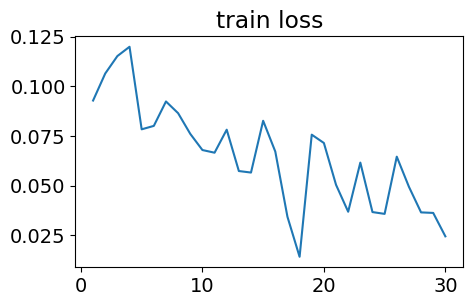

In [344]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), train_loss)
plt.title('train loss')

Text(0.5, 1.0, 'train accuracy')

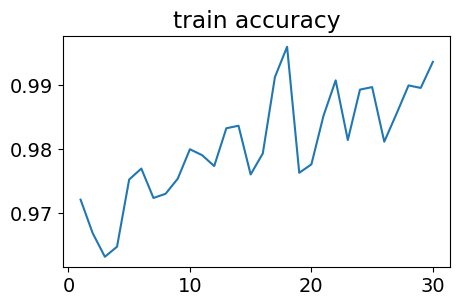

In [345]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), train_acc)
plt.title('train accuracy')

Text(0.5, 1.0, 'validation loss')

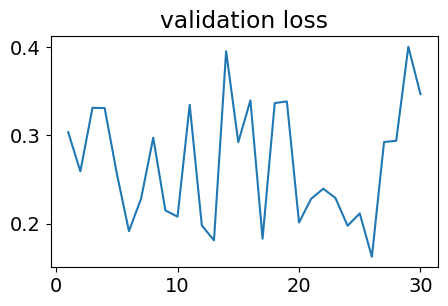

In [346]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), lossv)
plt.title('validation loss')

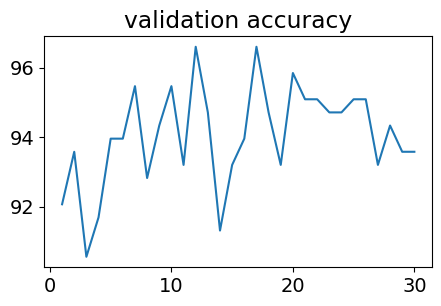

In [347]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), accv)
plt.title('validation accuracy');

In [381]:
import torch
import torch.nn as nn

def evaluate_model(model, loader, criterion):
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    print(f"Test Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy


In [382]:
evaluate_model(model, test_loader, criterion)

Test Loss: 0.3765 | Accuracy: 91.70%


(0.3764738424193403, 91.69811320754717)

**Я вибрав датасет для класифікації гральних карт за фото**
https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

**Обробка датасету**

Виконав ресайз до 80*80.

**1st Try**

Спочатку я затестив на базовій моделі із т
input 80*80*3 = 19200 => [8192, 2048, 512, 256, 128] => 53 output

**ResNet 50**

Також я розширив і нормалізував датасет шляхом трансформацій зображення.

Для задачі гарно б підійшли ResNet або VGG.
Я вирішив використати претреновану модель ResNet 50. Додавши на кінець Лінійний шар на 53 нейрони (відповідно до кількості класів)

Функція втрат = torch.nn.CrossEntropyLoss()
Оптимізатор   = torch.optim.Adam(model.parameters(), lr=0.001)

Модель дуже добре себе показала.

Validation set: Average loss: 0.3469, Accuracy: 248/265 (94%)
Train Epoch [30/30] - Loss: 0.0245 - Accuracy: 0.9936
Wall time: 47min 21s

На тестовому дата сеті:
Test Loss: 0.3765 | Accuracy: 91.70%

Для ще більшого поркащення можна не рескейлити зображення до 80*80 а брати станртове 150*150

